In [1]:
#Allows relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#imports 
from src.preprocessing import *
from src.models import deepcat_cnn
from src.train_eval_helpers import *
#from src.dataloader import *
from src.plots import * 

%load_ext autoreload
%autoreload 2
#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))

Using : cuda


In [3]:
TRAINDIR = '../TrainingData/'
KEYS = [12, 13, 14, 15, 16]
_, _, test_feats, test_labels = get_train_test_data(TRAINDIR, KEYS, device=None, shuffle=True, encoding='aaidx',scaling=None) 
_, _, richie_feats, richie_labels = get_train_test_data(TRAINDIR, KEYS, device=None, shuffle=True, encoding='aa_atchley',scaling='minmax')
models = load_models('../output/training_output/benchmark/')
#Need to go change some stuff in src.models.py if want to reload
#richie_models = load_models('../output/training_output/test_richie/', arch='richie')
#base_filters_models = load_models('../output/training_output/test_richie_base_filters', arch='richie', eval_=True)
rich = load_models('../output/training_output/richie_minmax_redo_withnograd/',
                     arch = 'richie', eval_=True)


Train
Getting data
Data device = cpu
Done loading, returning features and labels.

Test
Getting data
Data device = cpu
Done loading, returning features and labels.

Train
Getting data
Data device = cpu
Done loading, returning features and labels.

Test
Getting data
Data device = cpu
Done loading, returning features and labels.
Models & weights loaded
Models & weights loaded


In [4]:
_,_,_,_, curves = test_eval(rich, richie_feats, richie_labels, return_curve=True)

(<Figure size 4320x2880 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'ROC_AUC on test set for L = 12, total 3182 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:title={'center':'ROC_AUC on test set for L = 13, total 6412 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:title={'center':'ROC_AUC on test set for L = 14, total 8481 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>],
        [<AxesSubplot:title={'center':'ROC_AUC on test set for L = 15, total 7040 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:title={'center':'ROC_AUC on test set for L = 16, total 2846 samples (pos+neg)'}, xlabel='FPR', ylabel='TPR'>,
         <AxesSubplot:>]], dtype=object))

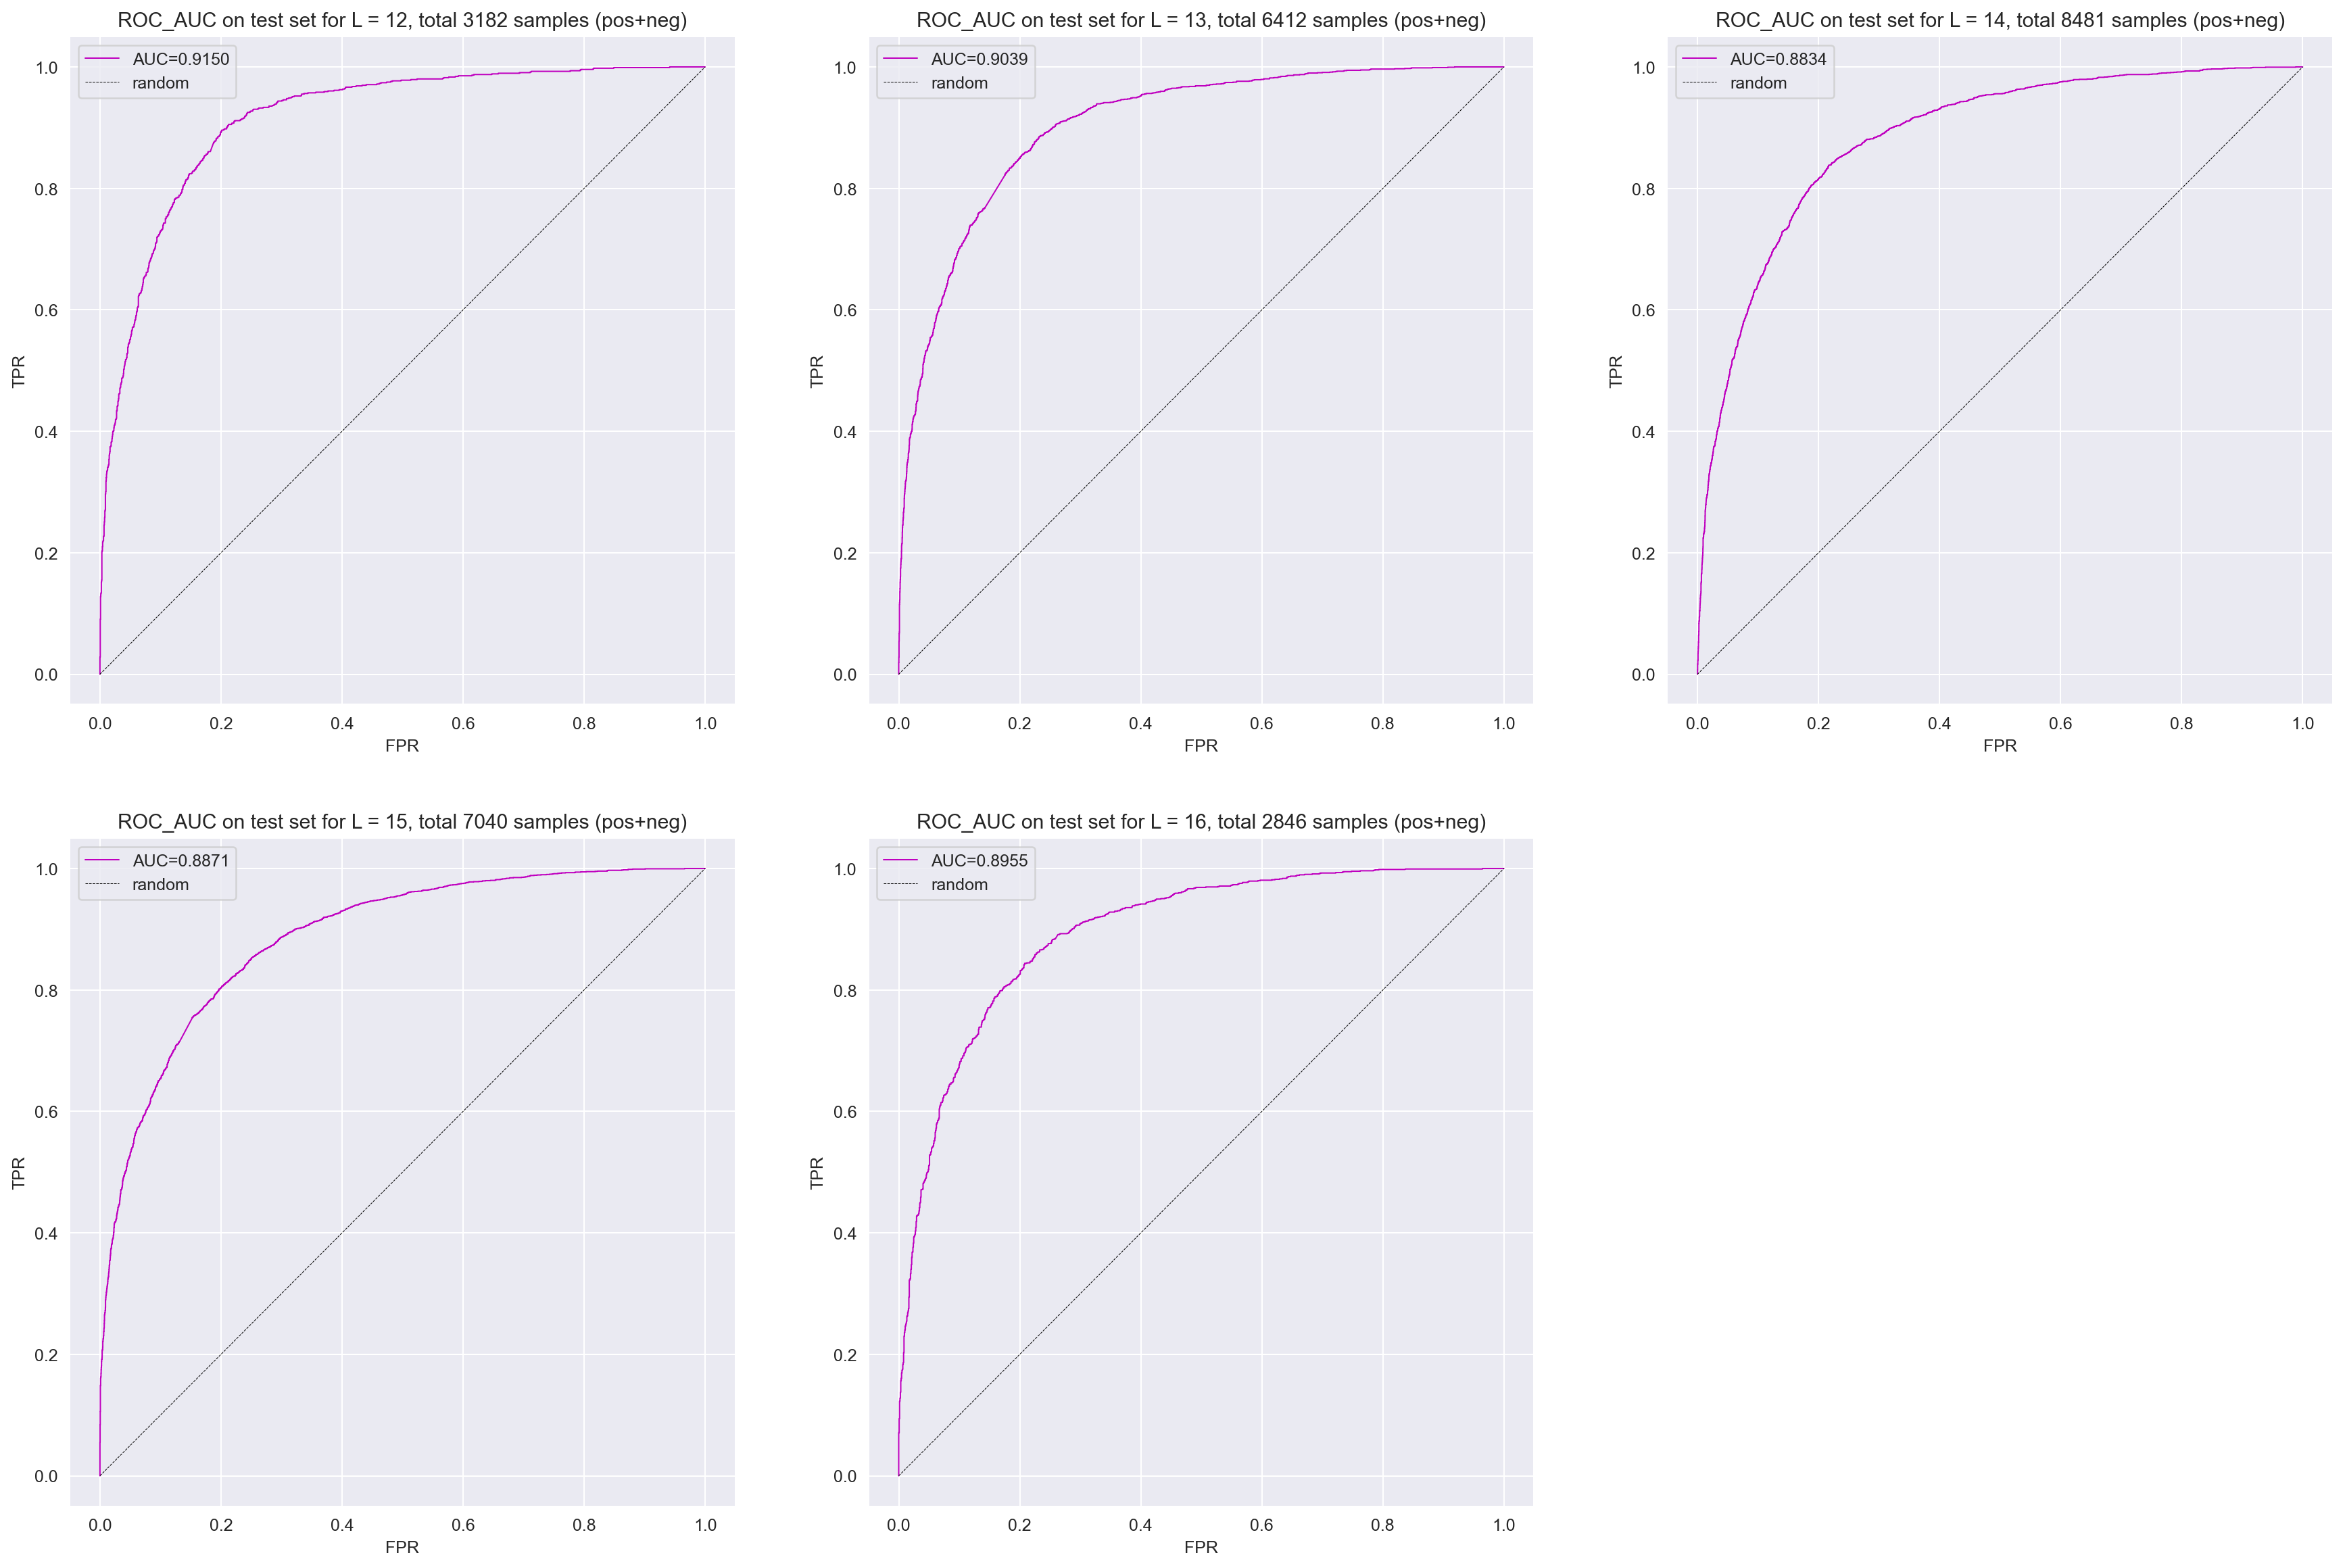

In [8]:
plot_roc_curve(curves, keys=range(12,17) ,save=None)

### Redoing PPVs on the same axes

In [ ]:
#Getting PPVs
preds_df = get_pred_df(models, test_feats, test_labels)
#plot_PPV(preds_df, save='PPV.jpg', folder = '../benchmark/')
richie_preds_df = get_pred_df(richie_models, richie_feats, richie_labels)
#plot_PPV(richie_preds_df, save='richie_PPV.jpg', folder = '../benchmark/')
#basefilters_df = get_pred_df(base_filters_models, richie_feats, richie_labels)

<ipython-input-4-11f2fb58108d>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_true).view(-1,1),#y_true
<ipython-input-4-11f2fb58108d>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(preds).view(-1,1), #predicted
<ipython-input-4-11f2fb58108d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(probs).view(-1,1)),1)#cat dimension


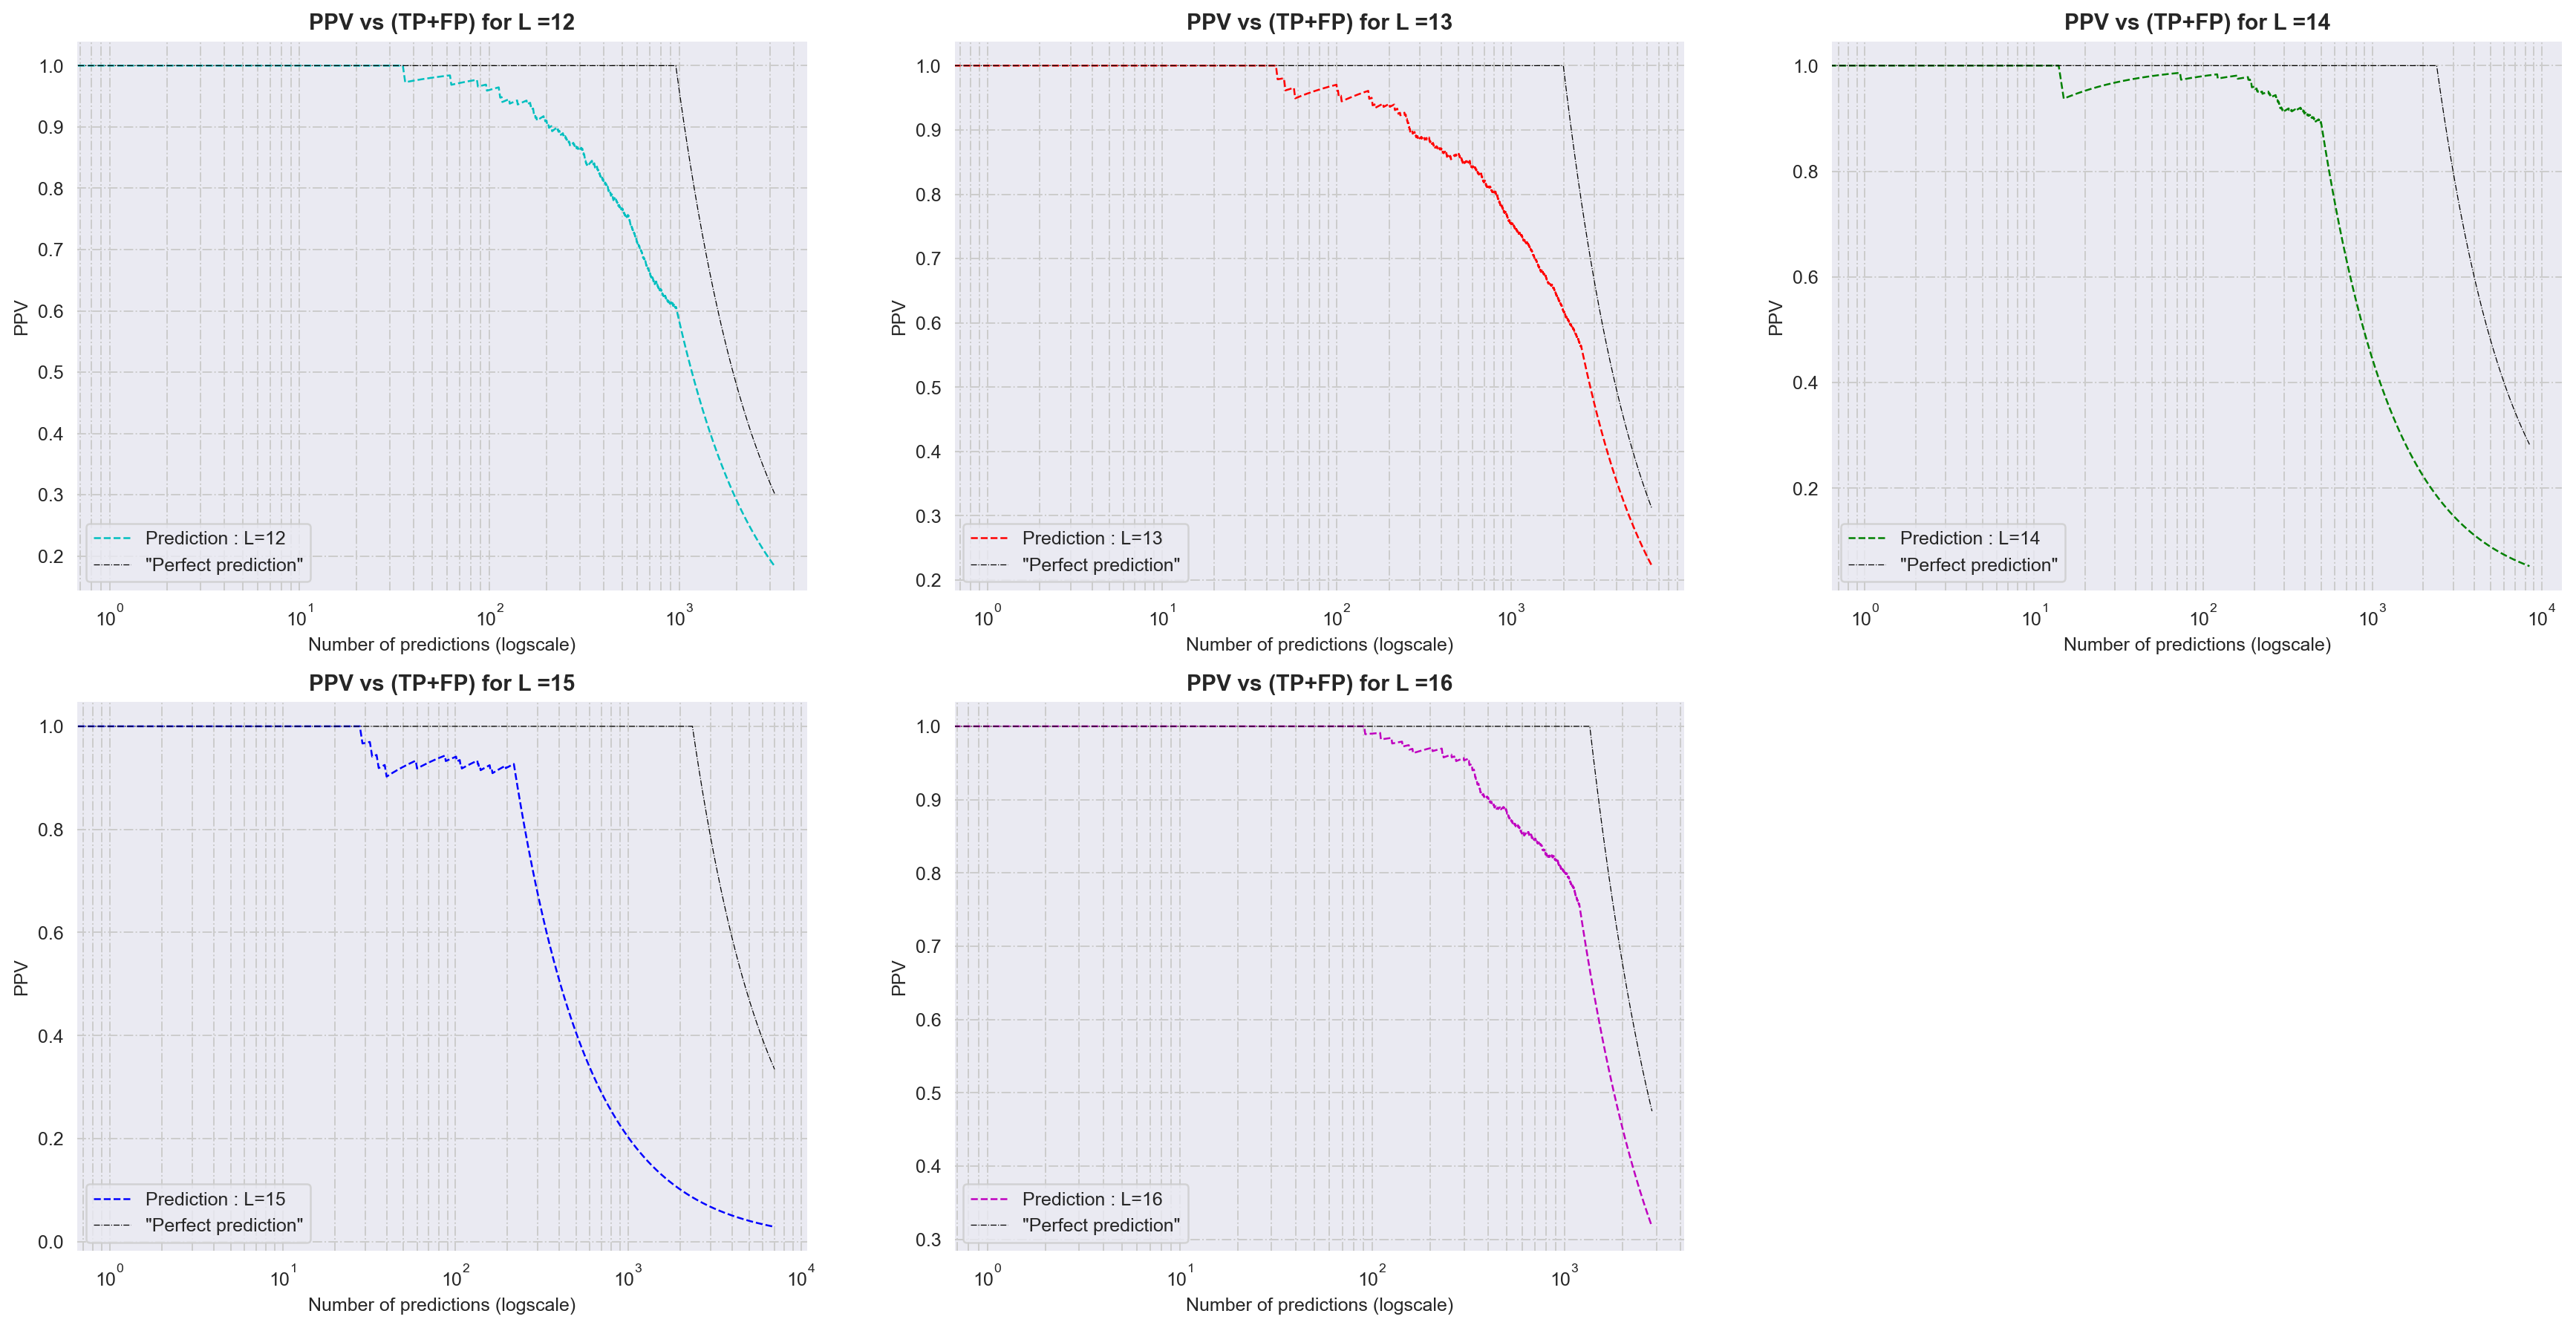

In [4]:
#Checking DeepCAT results : 
import pickle
DEEPCAT= '../../benchmark_results/DeepCAT/test_set/'
with open(DEEPCAT+'predict_probs.pkl', 'rb') as f:
    deepcat_probs = pickle.load(f)
    
with open(DEEPCAT+'aucdict.pkl', 'rb') as f:
    deepcat_aucs = pickle.load(f)
    
with open(DEEPCAT+'predict_label.pkl', 'rb') as f: #THESE ARE THE TRUE LABELS
    deepcat_labels = pickle.load(f)
    
#Getting PPV/ preds_df for DeepCAT results :
import pandas as pd
RANGE = KEYS
df = pd.DataFrame(columns = ['seqlen','y_true','predicted','prob_cancer',
                                 'tp','fp','tn','fn'])
for ll in RANGE: 
    #seqlen = ll.value
    probs = torch.tensor(deepcat_probs[ll])
    y_true = torch.tensor(deepcat_labels[ll]) #y_true
    preds = torch.tensor([1 if x>0.5 else 0 for x in probs])
    tmp_data = torch.cat((torch.full( (len(preds),1) , ll),#seqlen
                          torch.tensor(y_true).view(-1,1),#y_true
                          torch.tensor(preds).view(-1,1), #predicted
                          torch.tensor(probs).view(-1,1)),1)#cat dimension
    
    tmp = pd.DataFrame(data=tmp_data.numpy(),
                       columns =['seqlen','y_true','predicted','prob_cancer'])
    tmp['tp'] = tmp.apply(lambda x: 1 if (x['y_true']==x['predicted'] and x['predicted']==1) else 0, axis=1)
    tmp['fp'] = tmp.apply(lambda x: 1 if (x['y_true']!=x['predicted'] and x['predicted']==1) else 0, axis=1)
    tmp['tn'] = tmp.apply(lambda x: 1 if (x['y_true']==x['predicted'] and x['predicted']==0) else 0, axis=1)
    tmp['fn'] = tmp.apply(lambda x: 1 if (x['y_true']!=x['predicted'] and x['predicted']==0) else 0, axis=1)
    df = pd.concat([df,tmp], ignore_index=True)
    df=df.astype({'seqlen': 'int64', 'y_true':'int64','predicted':'int64',
                 'tp':'int64','fp':'int64','tn':'int64','fn':'int64'},copy=True)
    
#plot_PPV(df, save='DeepCAT_PPV.jpg', folder = '../benchmark/')

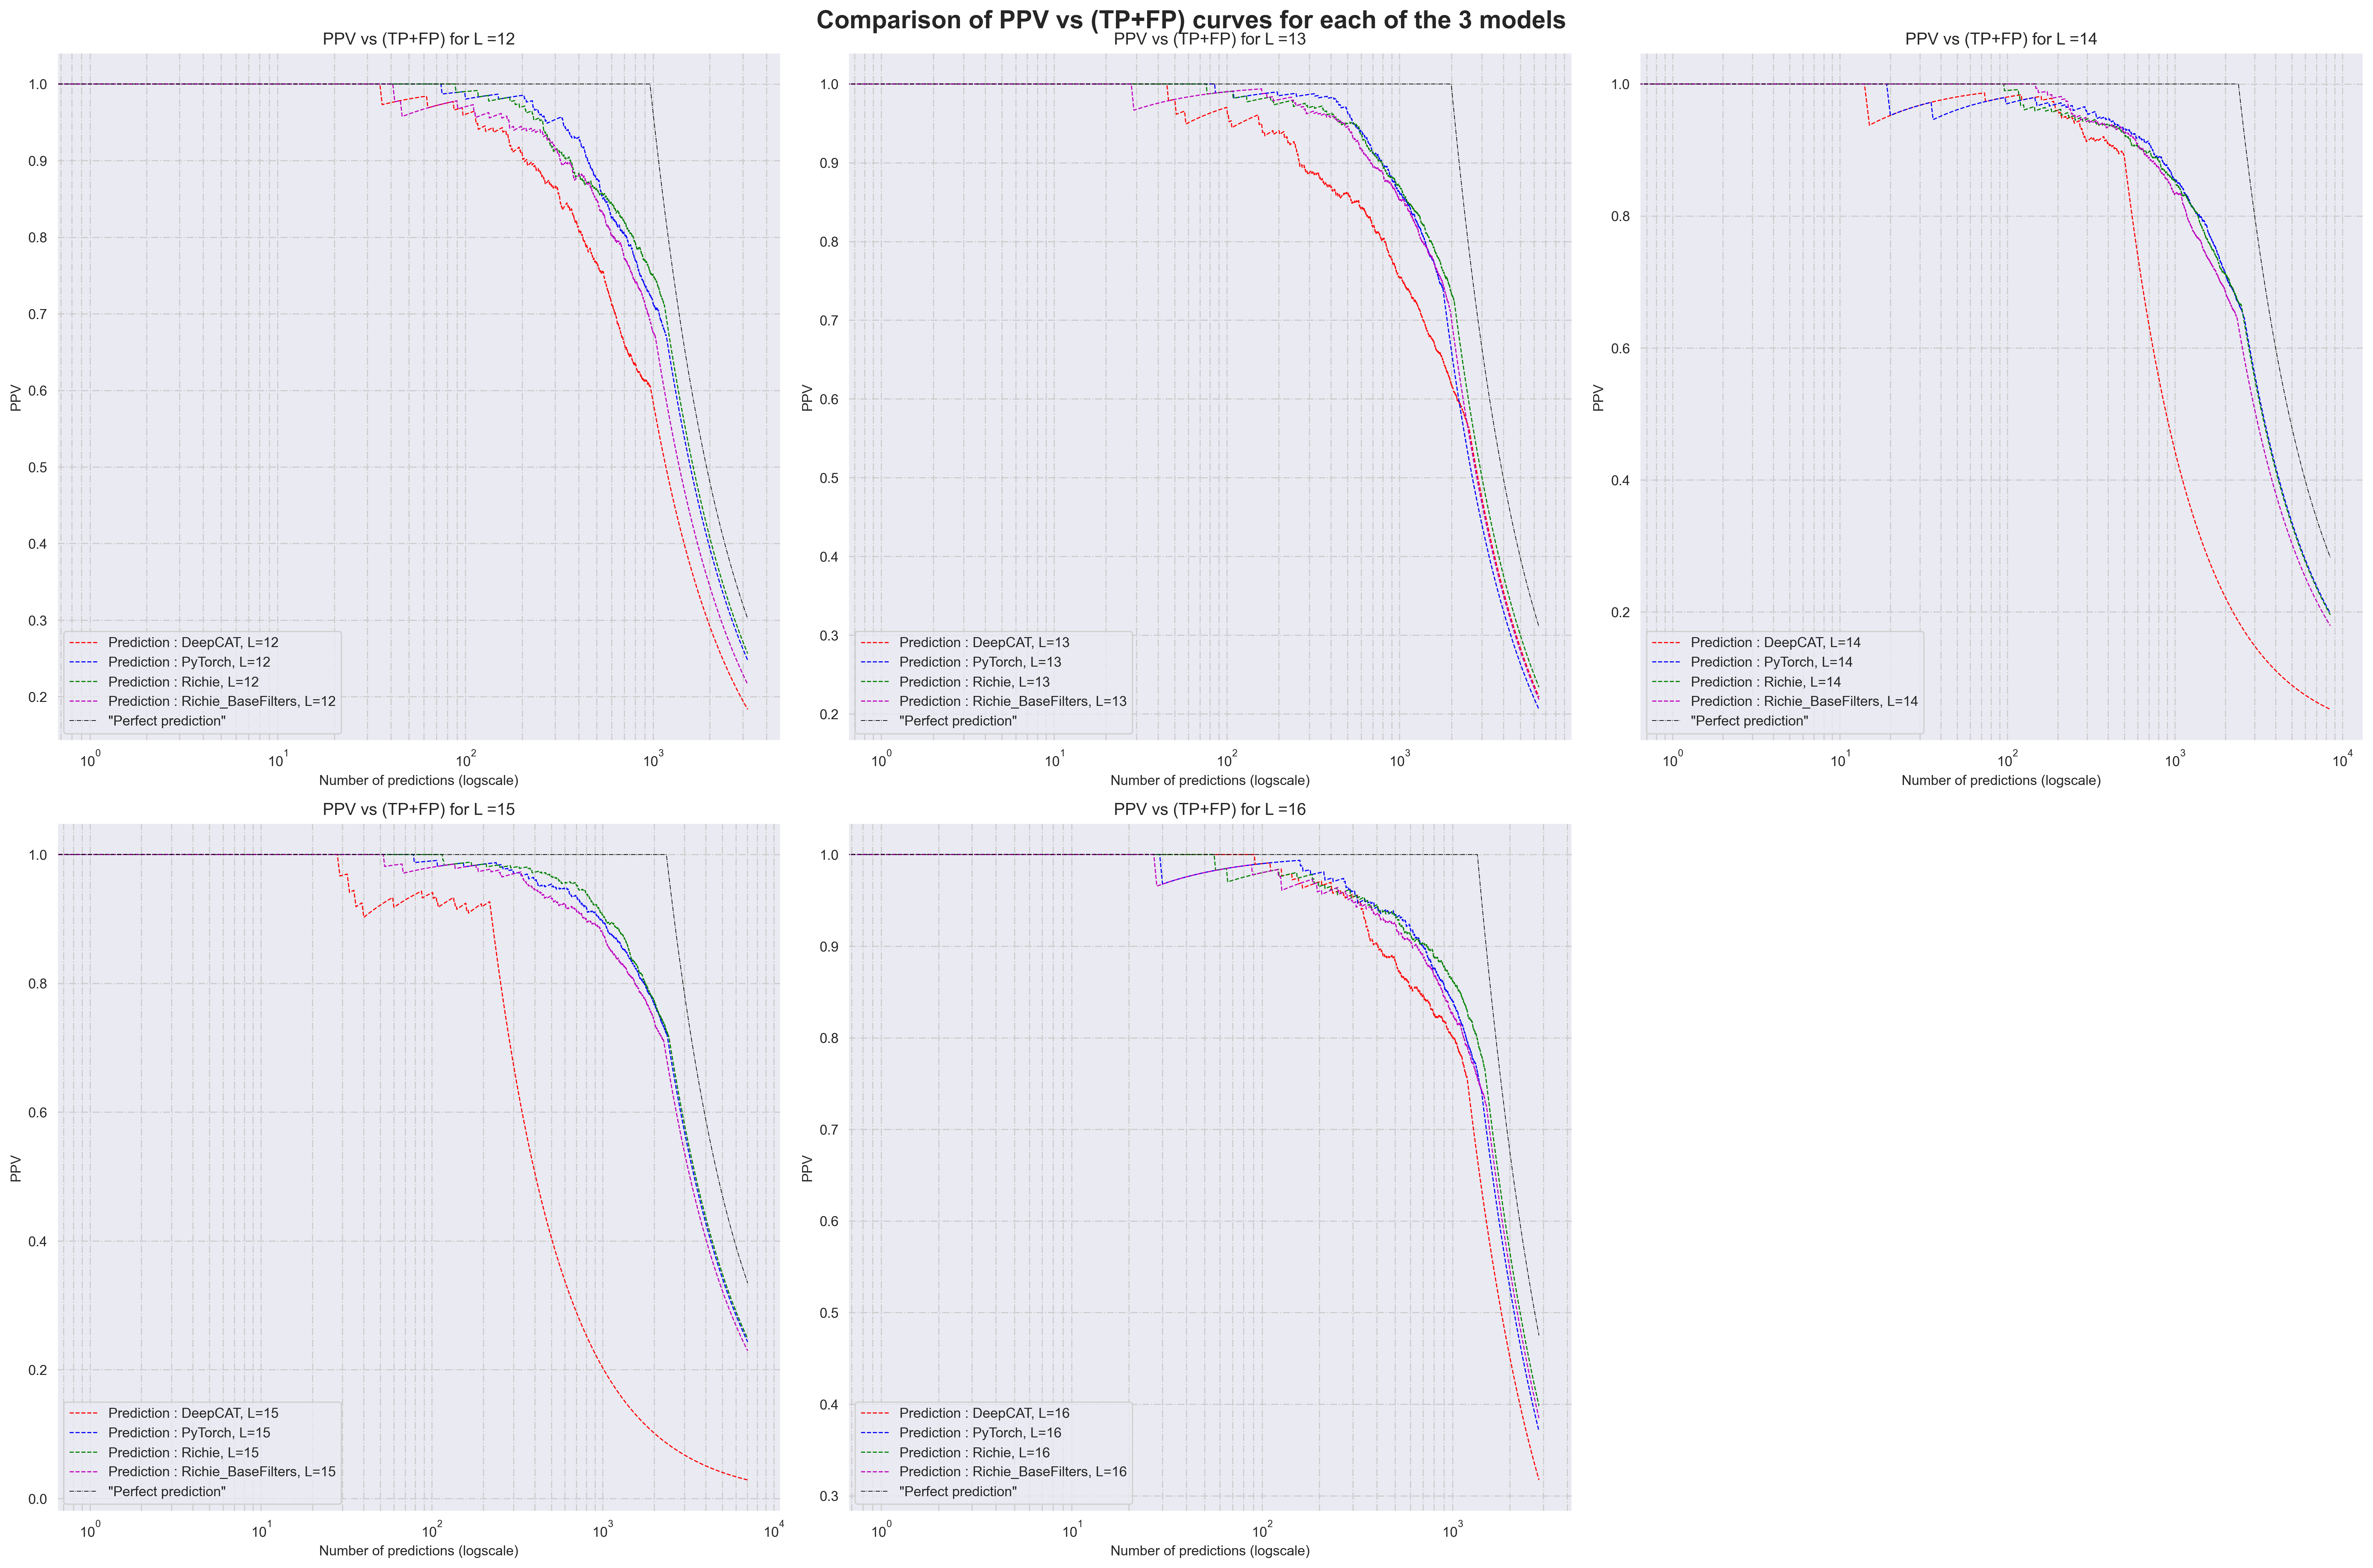

In [128]:
#
keys = df['seqlen'].unique()
num = len(keys) #Number of keys (plots needed)
fig, axes = plt.subplots(2,3, figsize = (24,16))

xs_pytorch=preds_df.sort_values('prob_cancer',ascending=False)\
     .groupby('seqlen')\
     .apply(lambda x: np.cumsum(x['tp'].values)/np.cumsum(np.ones(len(x['tp']))))

xs_deepcat=df.sort_values('prob_cancer',ascending=False)\
     .groupby('seqlen')\
     .apply(lambda x: np.cumsum(x['tp'].values)/np.cumsum(np.ones(len(x['tp']))))

xs_richie= richie_preds_df.sort_values('prob_cancer',ascending=False)\
     .groupby('seqlen')\
     .apply(lambda x: np.cumsum(x['tp'].values)/np.cumsum(np.ones(len(x['tp']))))

#xs_base = basefilters_df.sort_values('prob_cancer',ascending=False)\
#     .groupby('seqlen')\
#     .apply(lambda x: np.cumsum(x['tp'].values)/np.cumsum(np.ones(len(x['tp']))))

perfect = df.sort_values('y_true',ascending=False)\
            .groupby('seqlen')\
            .apply(lambda x: np.cumsum(x['y_true'].values)/np.cumsum(np.ones(len(x['y_true']))))

line = ['r--','b--','g--', 'm--']# deepcat, pytorch, richie

ax = axes.ravel()
for i, sl in enumerate(xs_pytorch.index):
    ax[i].semilogx(range(0,len(preds_df.query('seqlen==@sl')['tp'])), xs_deepcat[sl], 
                   line[0], lw=0.8, label='Prediction : DeepCAT, L={}'.format(sl))
    
    ax[i].semilogx(range(0,len(df.query('seqlen==@sl')['tp'])), xs_pytorch[sl], 
                   line[1], lw=0.8, label='Prediction : PyTorch, L={}'.format(sl))
    
    ax[i].semilogx(range(0,len(richie_preds_df.query('seqlen==@sl')['tp'])), xs_richie[sl], 
                   line[2], lw=0.8, label='Prediction : Richie, L={}'.format(sl))
    
    #ax[i].semilogx(range(0,len(richie_preds_df.query('seqlen==@sl')['tp'])), xs_base[sl], 
    #               line[3], lw=0.8, label='Prediction : Richie_BaseFilters, L={}'.format(sl))
    #
    ax[i].semilogx(range(0,len(df.query('seqlen==@sl')['y_true'])), perfect[sl],
                   'k-.', lw=0.5, label = '"Perfect prediction"')
    ax[i].legend(loc='best')
    ax[i].set_title('PPV vs (TP+FP) for L ={}'.format(sl))
    ax[i].set_ylabel('PPV')
    ax[i].set_xlabel('Number of predictions (logscale)')
#a.ygrid()
    ax[i].grid(True, which="both", ls="-.", color='0.8')

fig.suptitle('Comparison of PPV vs (TP+FP) curves for each of the 3 models', fontsize='18',fontweight='bold')
fig.subplots_adjust(top=0.85)
fig.tight_layout(pad=1.1)
fig.delaxes(ax[-1])
plt.savefig('../../benchmark_results/4_PPV_comparison.jpg', dpi=300)

### Redoing ROC curves

In [9]:
#Getting RICHIE ROC CURVES USING DEEPCAT METHOD (same plot)
for k in models.keys():
    models[k].to('cpu')
_, _, AUCs, _, curves = test_eval(models, KEYS, nn.CrossEntropyLoss(), test_feats, test_labels, return_curve=True)
#Using their plotting options
LLcolors=['b','g','r','c','m']
LegendLabels=[]
plt.figure(figsize=(7,7))
#font = {'family' : 'Arial',
#'weight' : 'normal',
#'size'   : 22}
#mpl.rc('font', **font)
hhList=[]
for LL in range(12,17):
    ycurve=curves[LL][1]
    hh,=plt.plot(ycurve[0],ycurve[1],LLcolors[LL-12],lw=2)
    hhList.append(hh)
    LegendLabels.append(str(LL)+' ('+str(np.round(curves[LL][0],4))+')')
plt.plot([0,1],[0,1],ls='dashed',lw=2)
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive Rate',fontsize=22)
legend=plt.legend(hhList,LegendLabels,fontsize=12,title='Length (AUC)')
plt.show()
plt.savefig('../benchmark/roc_auc.jpg',dpi=300)

In [133]:
from sklearn.metrics import roc_curve
pytorch_curves = curves
deepcat_curves = {}
#Using my architecture
#with open('../../benchmark_results/richie/roc_curves_dict.pkl', 'rb') as g:
#    richie_curves = pickle.load(g)
#    
with open('../output/training_output/test_richie_base_filters/dicts/roc_curves_dict.pkl', 'rb') as g:
    base_curves = pickle.load(g)
for key in range(12,17):
    deepcat_curves[key] = (deepcat_aucs[key], roc_curve(deepcat_labels[key], deepcat_probs[key]))

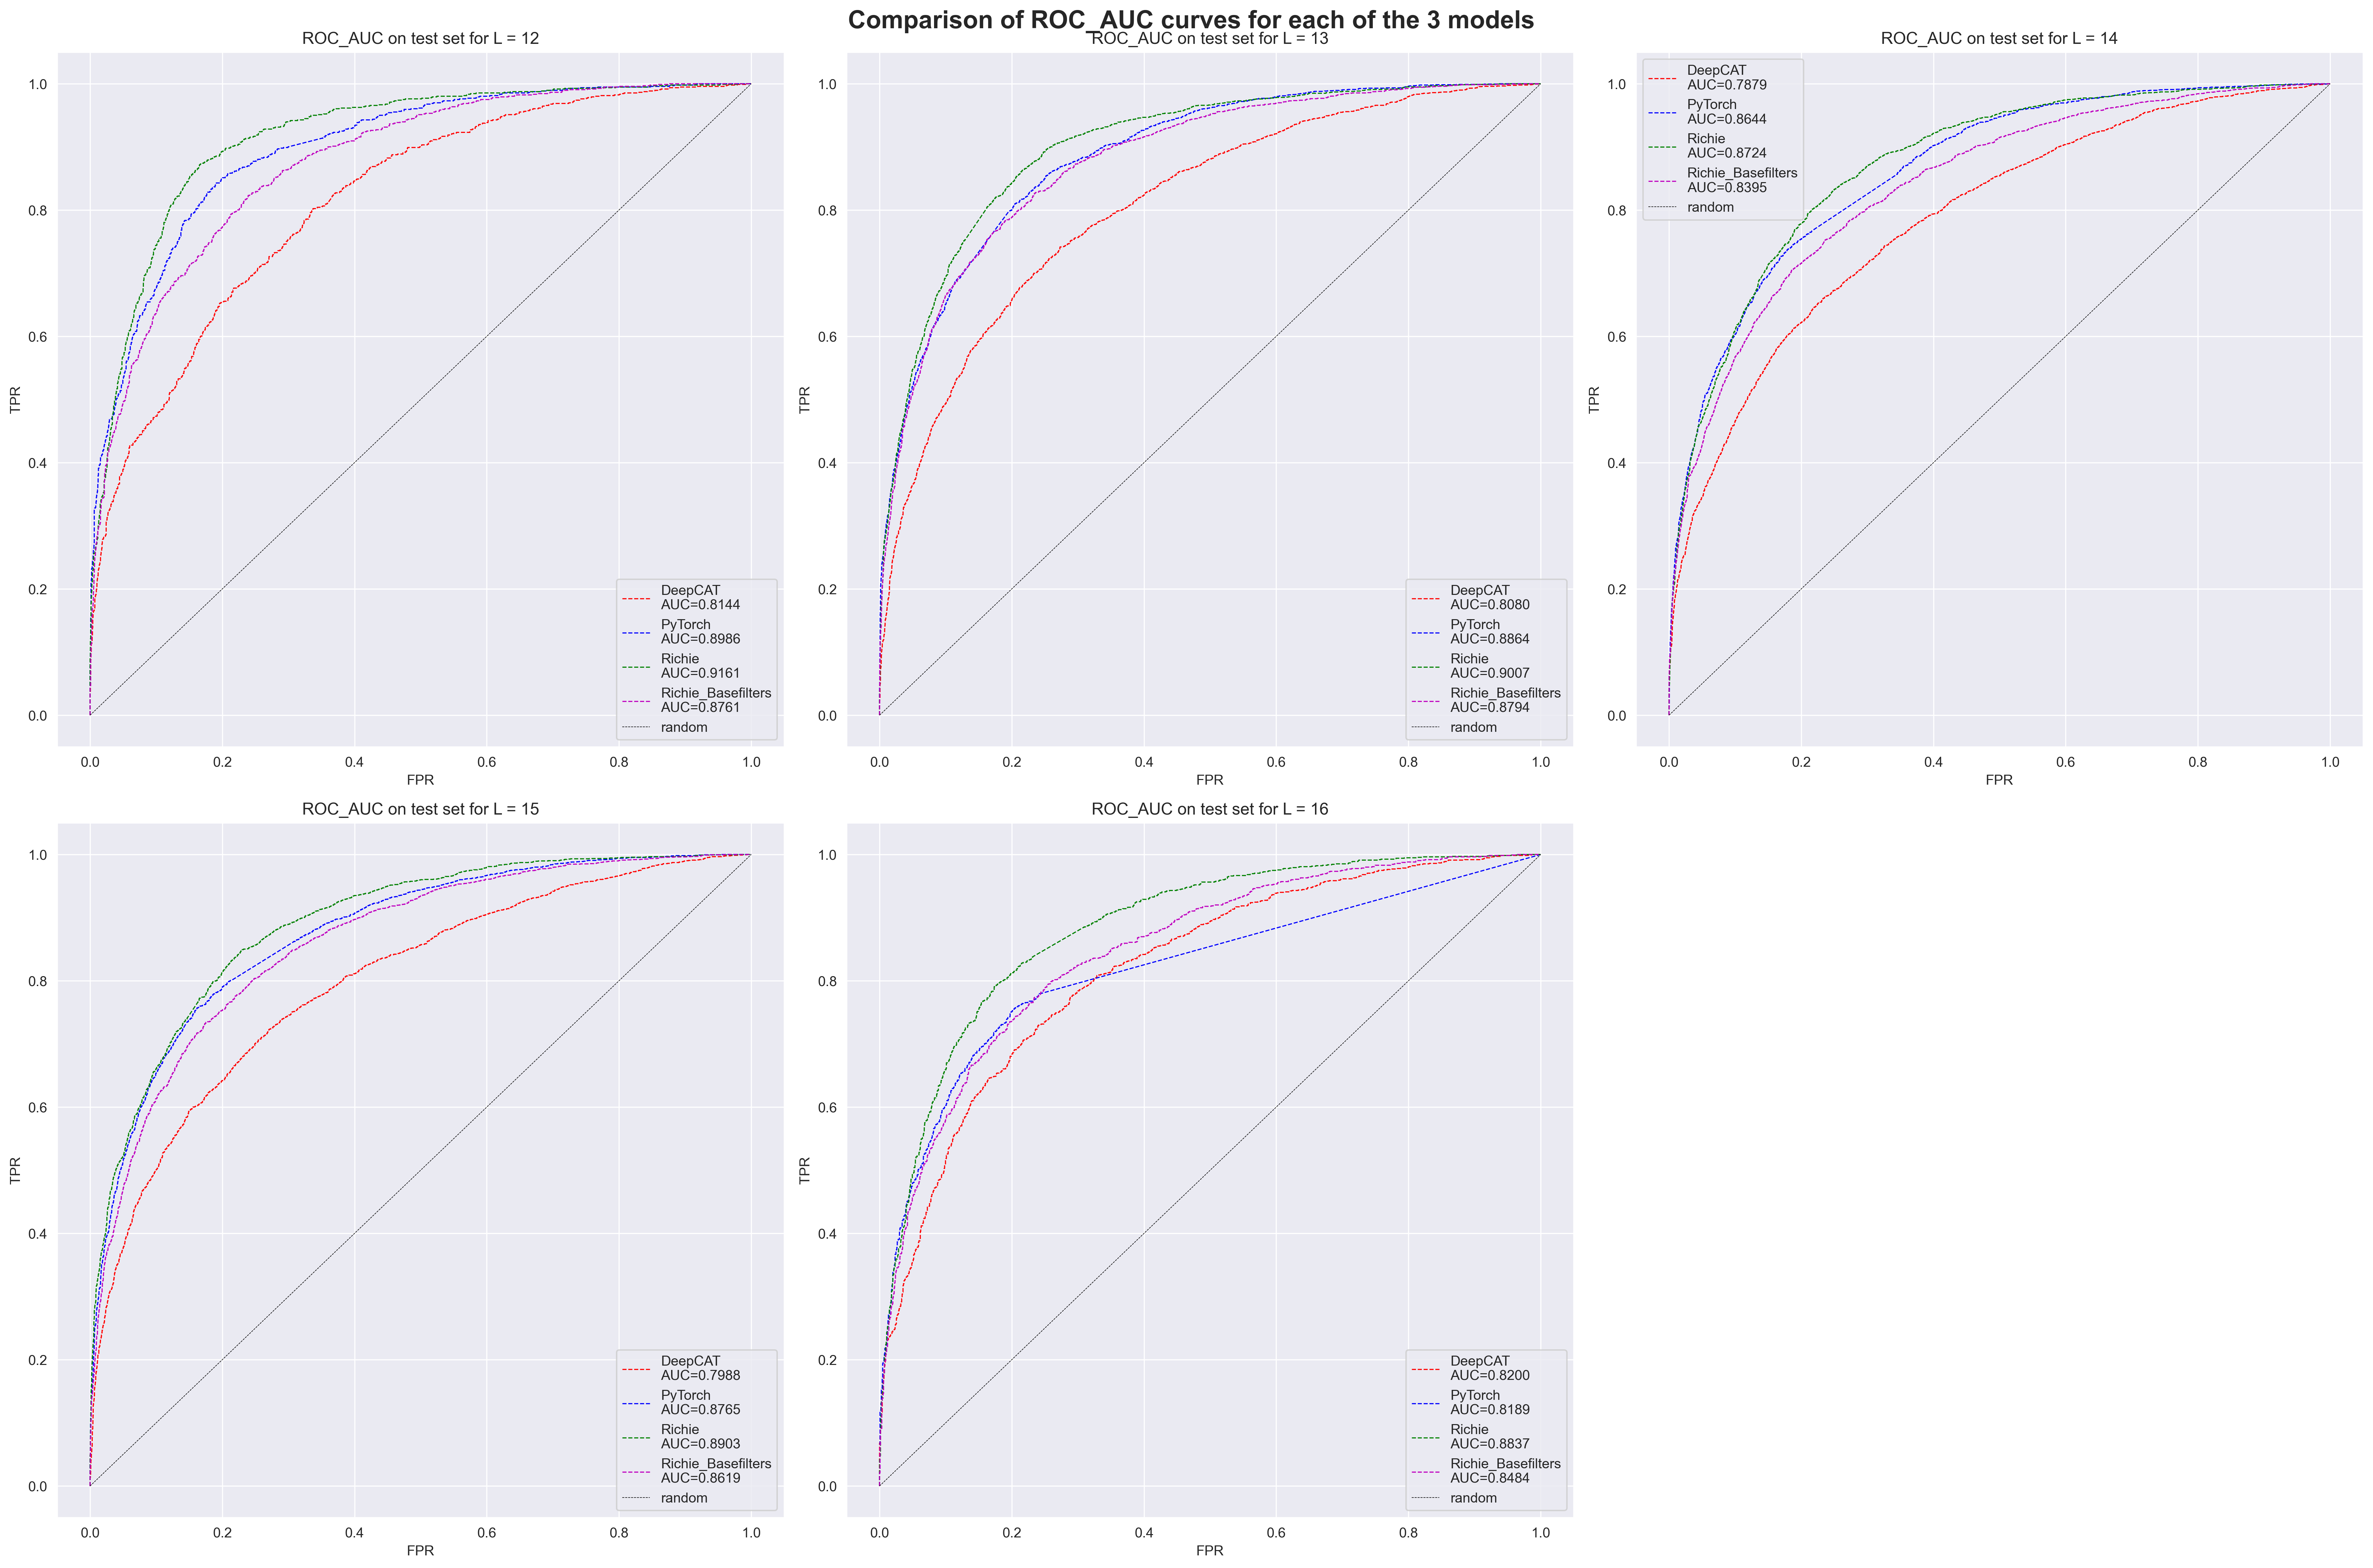

In [135]:
#def plot_roc_curve(curve_dict, keys, save = 'roc_curves.jpg', folder=None):
#Redoing the roc curves manually 
fig, axes = plt.subplots(2,3, figsize = (24,16))
ax = axes.ravel() 
for index, ll in enumerate([12,13,14,15,16]):
    pts = np.linspace(0,1, 100)
    ax[index].plot(deepcat_curves[ll][1][0], deepcat_curves[ll][1][1],
                   'r--', lw = 0.8, label = 'DeepCAT\nAUC={:.4f}'.format(deepcat_curves[ll][0]))
    ax[index].plot(pytorch_curves[ll][1][0], pytorch_curves[ll][1][1],
                   'b--', lw = 0.8, label = 'PyTorch\nAUC={:.4f}'.format(pytorch_curves[ll][0]))
    ax[index].plot(richie_curves[ll][1][0], richie_curves[ll][1][1],
                   'g--', lw = 0.8, label = 'Richie\nAUC={:.4f}'.format(richie_curves[ll][0]))
    ax[index].plot(base_curves[ll][1][0], base_curves[ll][1][1],
                   'm--', lw = 0.8, label = 'Richie_Basefilters\nAUC={:.4f}'.format(base_curves[ll][0]))
    ax[index].plot(pts, pts, 'k--', lw = '0.4', label = 'random')
    ax[index].legend(loc='best')
    ax[index].set_title('ROC_AUC on test set for L = {}'.format(ll))
    ax[index].set_xlabel('FPR')
    ax[index].set_ylabel('TPR')
fig.suptitle('Comparison of ROC_AUC curves for each of the 3 models', fontsize='18',fontweight='bold')
fig.subplots_adjust(top=0.85)
fig.tight_layout(pad=1.1)
fig.delaxes(ax[-1])
plt.savefig('../../benchmark_results/4ROC_comparison.jpg', dpi=300)

### BOXPLOTS FOR CANCER_SCORE COMPARISON

In [112]:
total = pd.concat([cancer_deep, control_deep,
                   cancer_pytorch, control_pytorch,
                   cancer, control], ignore_index=True)

In [114]:
# BOXPLOTS for patient score
deep='../../benchmark_results/DeepCAT/patients/Cancer_score_'
pytorch='../../benchmark_results/DeepTCR_PyTorch/patients_pytorch/cancer_scores'
richie='../../benchmark_results/richie/patients_richie/cancer_scores'
base = '../output/run_output/richie_preds_base_filters/cancer_scores'


def get_df(path, type_, mod):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['name','cancer_score']
    df['type'] = type_
    df['model'] = mod  
    return df 

cancer_rich = get_df(richie+'Cancer.txt', 'cancer','Richie')
control_rich = get_df(richie+'Control.txt','control', 'Richie')

cancer_deep = get_df(deep+'Cancer.txt','cancer','DeepCAT')
control_deep = get_df(deep+'Control.txt','control','DeepCAT')

cancer_pytorch = get_df(pytorch+'Cancer.txt', 'cancer','PyTorch')
control_pytorch = get_df(pytorch+'Control.txt','control', 'PyTorch')

cancer = get_df(base+'Cancer.txt', 'cancer','Richie_baseFilters')
control =  get_df(base+'Control.txt','control', 'Richie_baseFilters')

total = pd.concat([cancer_deep, control_deep,
                   cancer_pytorch, control_pytorch,
                   cancer, control], ignore_index=True)
total=total[['cancer_score','type','model']]
total.sample(3)

cancer_score    type               model
3        0.246631  cancer             DeepCAT
2        0.335434  cancer             DeepCAT
152      0.434708  cancer  Richie_baseFilters

In [115]:
from statsmodels.stats.weightstats import ttest_ind as ttest
from scipy import stats
pval_basefilters = ttest(total.query('type=="cancer"&model=="Richie_baseFilters"')['cancer_score'], total.query('type=="control"&model=="Richie_baseFilters"')['cancer_score'])[1]
pval_pytorch = ttest(total.query('type=="cancer"&model=="PyTorch"')['cancer_score'], total.query('type=="control"&model=="PyTorch"')['cancer_score'])[1]
pval_richie = ttest(total.query('type=="cancer"&model=="Richie"')['cancer_score'], total.query('type=="control"&model=="Richie"')['cancer_score'])[1]
pval_deepcat = ttest(total.query('type=="cancer"&model=="DeepCAT"')['cancer_score'], total.query('type=="control"&model=="DeepCAT"')['cancer_score'])[1]

In [108]:
print("torch",stats.bartlett(total.query('type=="cancer"&model=="PyTorch"')['cancer_score'], total.query('type=="control"&model=="PyTorch"')['cancer_score']))
print("richie",stats.bartlett(total.query('type=="cancer"&model=="Richie"')['cancer_score'], total.query('type=="control"&model=="Richie"')['cancer_score']))
print("torch",stats.bartlett(total.query('type=="cancer"&model=="DeepCAT"')['cancer_score'], total.query('type=="control"&model=="DeepCAT"')['cancer_score']))

torch LeveneResult(statistic=0.22037693942761546, pvalue=0.6410709613655072)
richie LeveneResult(statistic=0.09090180145380734, pvalue=0.7644541903047359)
torch LeveneResult(statistic=1.3340645976264414, pvalue=0.2543176317504775)


In [116]:
total.query('type=="control"').sort_values('cancer_score',ascending=False).head()

cancer_score     type               model
178      0.437700  control  Richie_baseFilters
132      0.428821  control              Richie
86       0.403169  control             PyTorch
161      0.318519  control  Richie_baseFilters
179      0.309492  control  Richie_baseFilters

In [ ]:
#PLOTTING ALL 4 
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
sns.set_style('darkgrid')
sns.set_palette('coolwarm',n_colors=2)
#Actual plots (box+swarm)
f,a = plt.subplots(figsize=(15,9))
sns.boxplot(data=total[['cancer_score','type','model']], x='model', hue ='type', y= 'cancer_score', ax = a)
sns.swarmplot(data=total[['cancer_score','type','model']], x='model', hue ='type', y= 'cancer_score', ax = a, edgecolor='black', linewidth=0.5)

#Annotating (outlier name)
plt.annotate("Patient\nHIP09681", (0.03, total.iloc[40]['cancer_score']-0.012))
plt.annotate("Patient\nHIP09681", (1.03, total.iloc[86]['cancer_score']-0.01))
plt.annotate("Patient\nHIP09681", (2.03, total.iloc[132]['cancer_score']-0.012))
plt.annotate("Patient\nHIP09681", (3.03, total.iloc[178]['cancer_score']-0.012))

#Setting lims to make pvalue annotation
a.set_ylim(0.1,0.48)
#plt.subplots_adjust(top=0.95)
a.set_title('Comparison of predicted patient cancer scores using DeepCAT pretrained model vs PyTorch implementation')

y1, y2 = 0.46, 0.465
a.plot([-0.2, -0.2, 0.2, 0.2], [y1, y2, y2, y1], lw=1.5, c='k')
a.text(0, 0.47, "p = {pv:.3e}".format(pv=pval_deepcat), ha='center', va='center', color='k')

a.plot([0.8, 0.8, 1.2, 1.2], [y1, y2, y2, y1], lw=1.5, c='k')#[0.405, 0.41, 0.41, 0.405], lw=1.5, c='k')
a.text(1, 0.47, "p = {pv:.3e}".format(pv=pval_pytorch), ha='center', va='center', color='k')

a.plot([1.8, 1.8, 2.2, 2.2], [y1, y2, y2, y1], lw=1.5, c='k')
a.text(2, 0.47, "p = {pv:.3e}".format(pv=pval_richie), ha='center', va='center', color='k')

a.plot([2.8, 2.8, 3.2, 3.2], [y1, y2, y2, y1], lw=1.5, c='k')
a.text(3, 0.47, "p = {pv:.3e}".format(pv=pval_basefilters), ha='center', va='center', color='k')


plt.show()
f.tight_layout()
f.savefig('../../benchmark_results/4boxplots.png', dpi=300)#

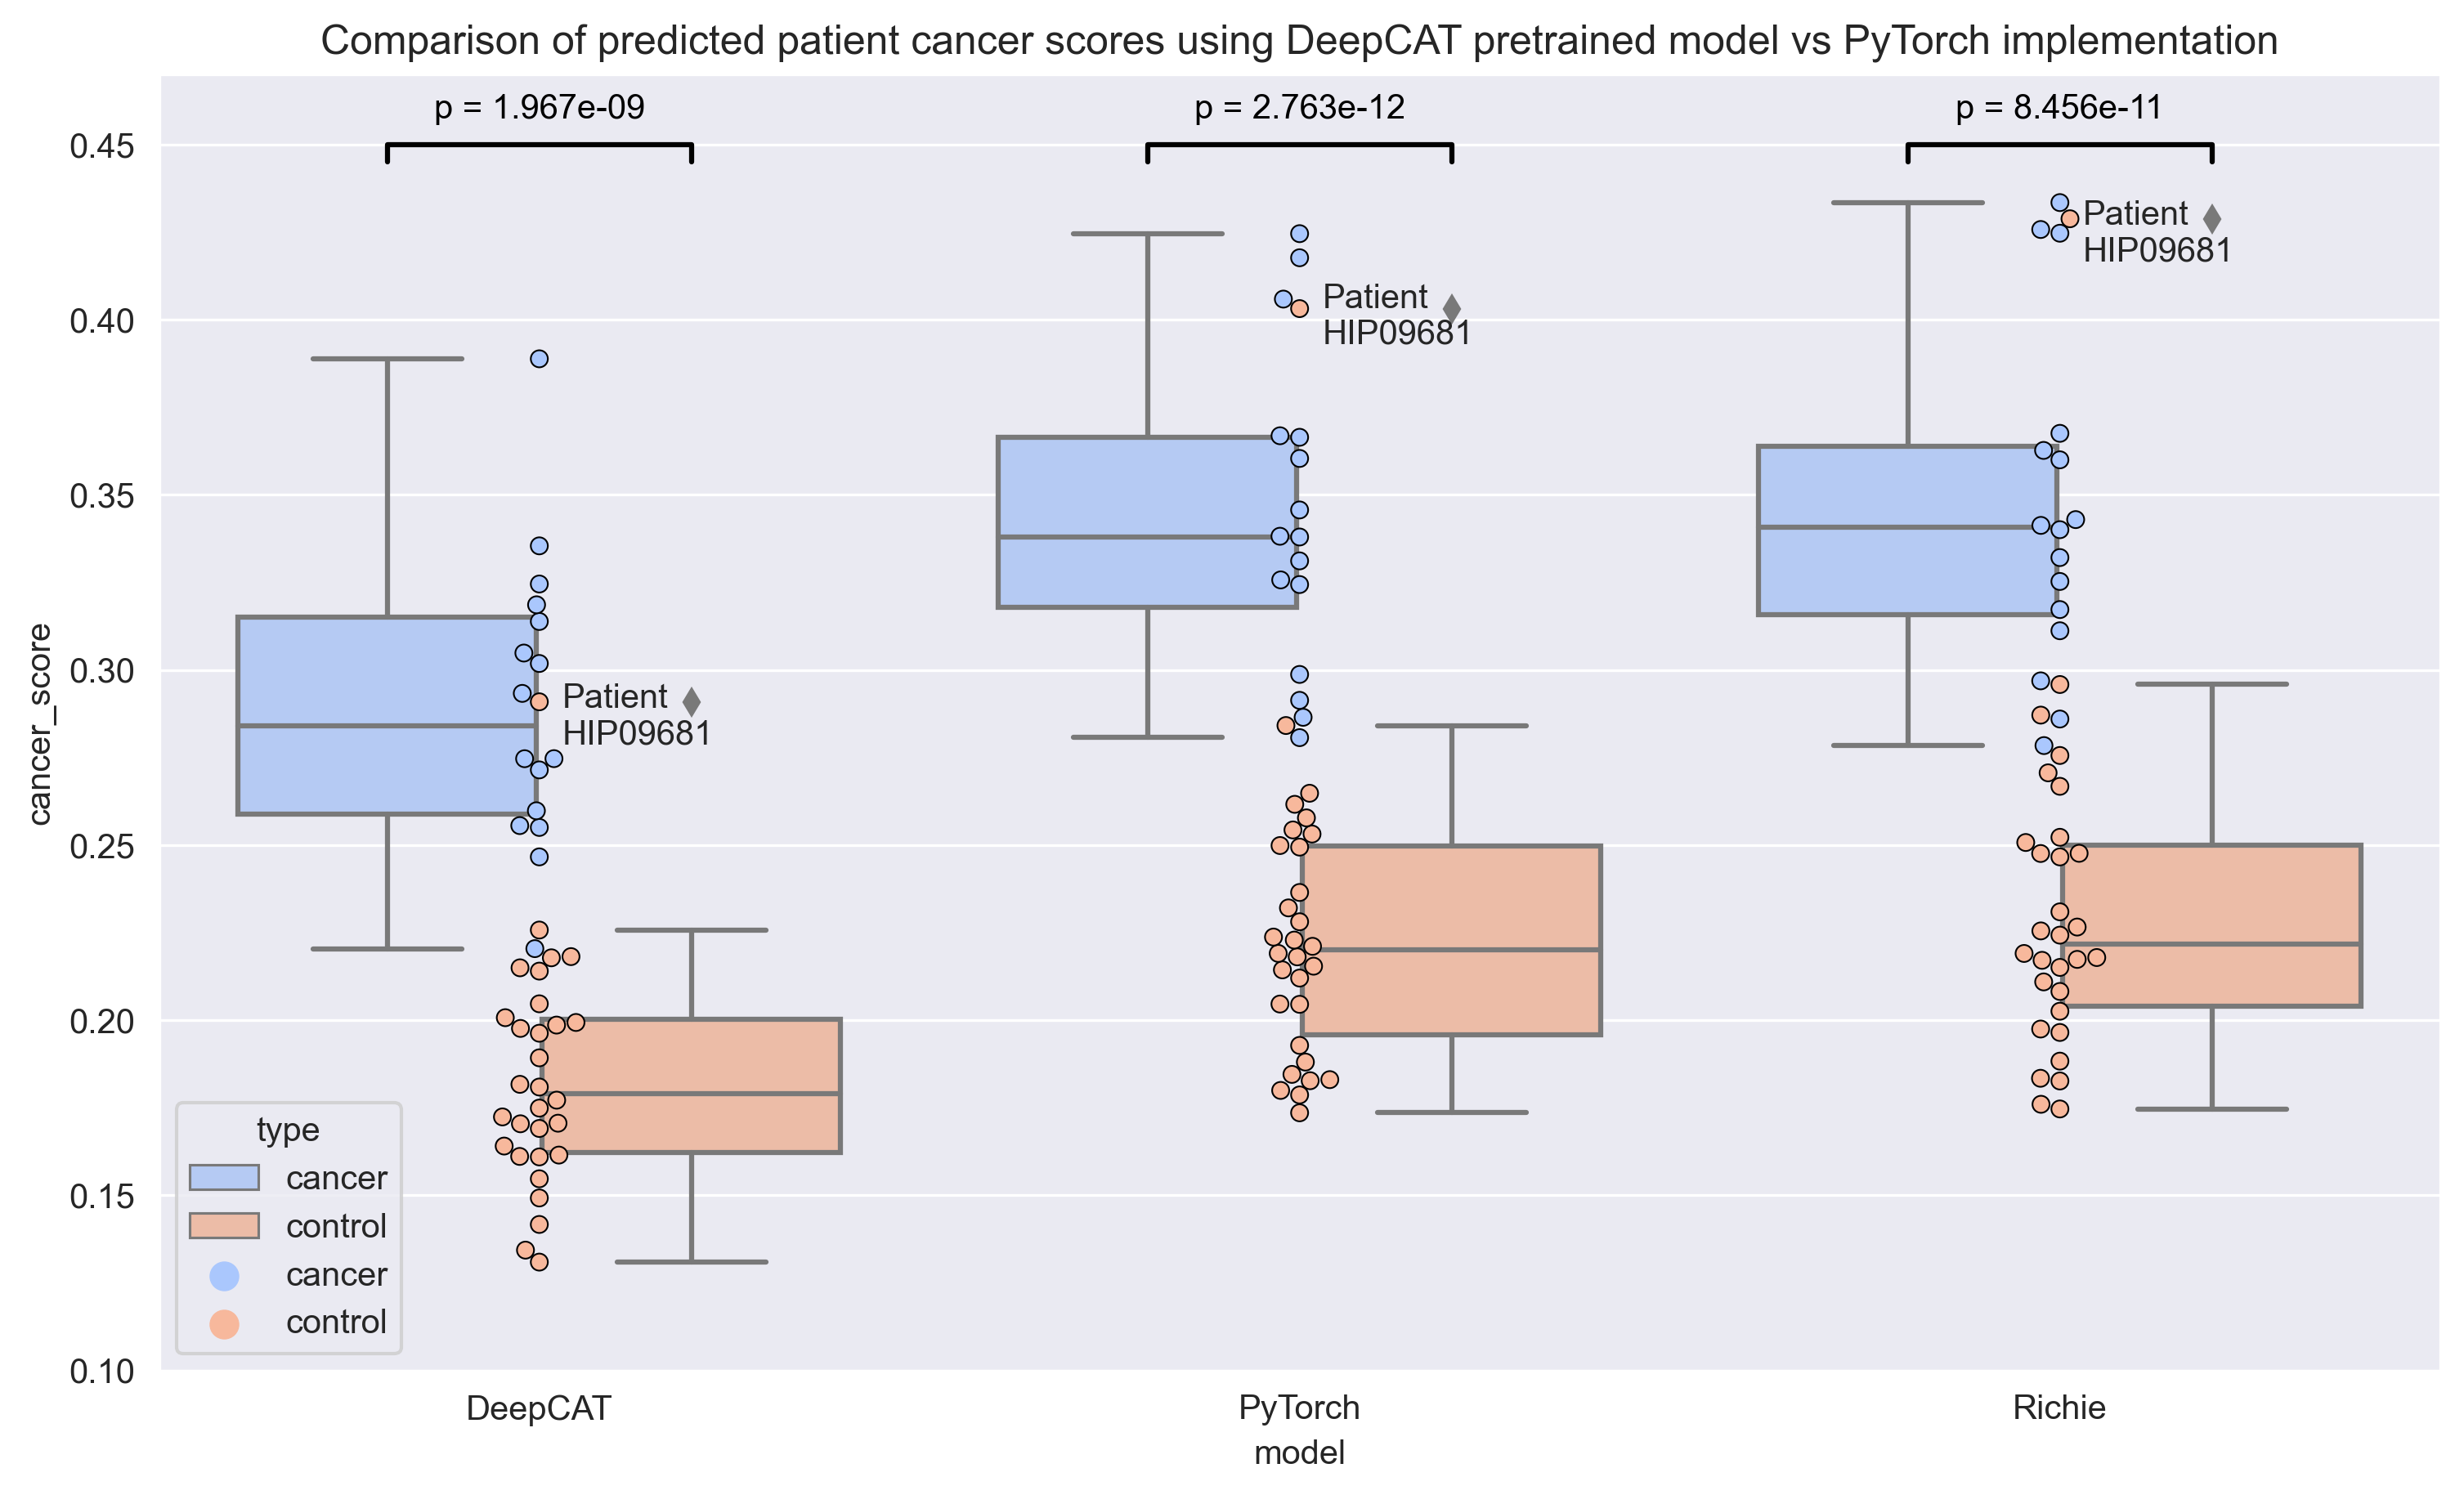

In [138]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
sns.set_style('darkgrid')
sns.set_palette('coolwarm',n_colors=2)
#Actual plots (box+swarm)
f,a = plt.subplots(figsize=(12,7))

sns.boxplot(data=total.query('model!="Richie_baseFilters"')[['cancer_score','type','model']], x='model', hue ='type', y= 'cancer_score', ax = a)
sns.swarmplot(data=total.query('model!="Richie_baseFilters"')[['cancer_score','type','model']], x='model', hue ='type', y= 'cancer_score', ax = a, edgecolor='black', linewidth=0.5)

#Annotating (outlier name)
plt.annotate("Patient\nHIP09681", (0.03, total.iloc[40]['cancer_score']-0.012))
plt.annotate("Patient\nHIP09681", (1.03, total.iloc[86]['cancer_score']-0.01))
plt.annotate("Patient\nHIP09681", (2.03, total.iloc[132]['cancer_score']-0.012))

#Setting lims to make pvalue annotation
a.set_ylim(0.1,0.47)
#plt.subplots_adjust(top=0.95)
a.set_title('Comparison of predicted patient cancer scores using DeepCAT pretrained model vs PyTorch implementation')
#
a.plot([-0.2, -0.2, 0.2, 0.2], [0.445, 0.45, 0.45, 0.445], lw=1.5, c='k')
a.text(0, 0.46, "p = {pv:.3e}".format(pv=pval_richie), ha='center', va='center', color='k')

a.plot([0.8, 0.8, 1.2, 1.2], [0.445, 0.45, 0.45, 0.445], lw=1.5, c='k')#[0.405, 0.41, 0.41, 0.405], lw=1.5, c='k')
a.text(1, 0.46, "p = {pv:.3e}".format(pv=pval_deepcat), ha='center', va='center', color='k')

a.plot([1.8, 1.8, 2.2, 2.2], [0.445, 0.45, 0.45, 0.445], lw=1.5, c='k')
a.text(2, 0.46, "p = {pv:.3e}".format(pv=pval_pytorch), ha='center', va='center', color='k')

plt.show()
f.tight_layout()
f.savefig('../../benchmark_results/3boxplots.png', dpi=300)#